In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_excel('/Users/koushik.saha/Repos/Segmentation/T1/Online Retail.xlsx', engine='openpyxl')
df = df[df['CustomerID'].notna()]
# Sample the dataset
# df_fix = df.sample(10000, random_state = 42)
df_fix = df

In [3]:
df.shape

(406829, 8)

In [4]:
df_fix.shape

(406829, 8)

In [5]:
df_fix.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df_fix['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [7]:
df_fix['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [8]:
df_fix['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2070
REGENCY CAKESTAND 3 TIER              1905
JUMBO BAG RED RETROSPOT               1662
ASSORTED COLOUR BIRD ORNAMENT         1418
PARTY BUNTING                         1416
                                      ... 
BLACK FINE BEAD NECKLACE W TASSEL        1
GREEN/BLUE CERAMIC CANDLE HOLDER         1
FIRE POLISHED GLASS NECKL GOLD           1
WHITE CHERRY LIGHTS                      1
WHITE ROSEBUD & PEARL NECKLACE           1
Name: Description, Length: 3896, dtype: int64

In [9]:
from datetime import datetime
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date

In [10]:
# Create TotalSum colummn
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]

In [11]:
# Create date variable that records recency
import datetime
snapshot_date = max(df_fix['InvoiceDate']) + datetime.timedelta(days=1)

# Aggregate data by each customer
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

In [12]:
customers

,InvoiceDate,InvoiceNo,TotalSum
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,13,176.60


In [13]:
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [14]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


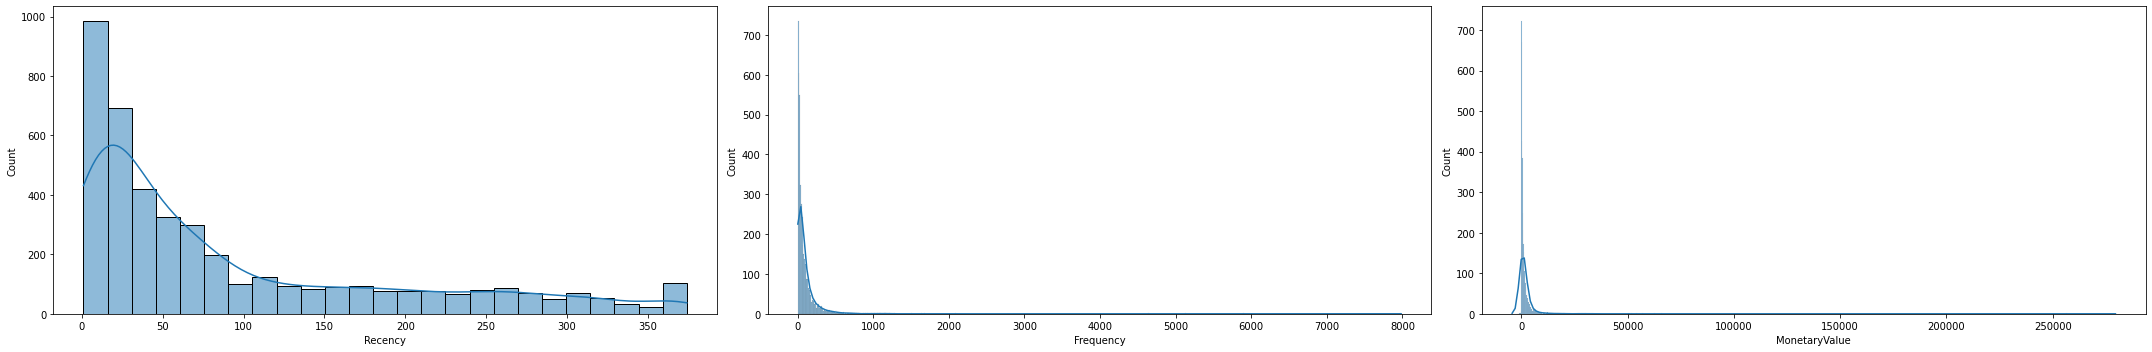

In [15]:
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(30,5))
sns.histplot(customers['Recency'], ax=ax[0], kde=True)
sns.histplot(customers['Frequency'], ax=ax[1], kde=True)
sns.histplot(customers['MonetaryValue'], ax=ax[2], kde=True)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Recency', ylabel='Density'>

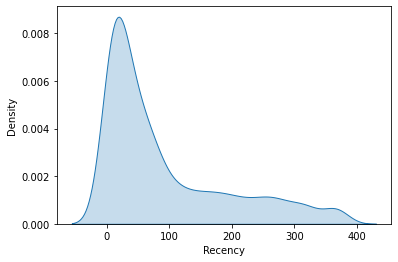

In [16]:
sns.kdeplot(customers['Recency'], shade=True)

<AxesSubplot:xlabel='Frequency', ylabel='Density'>

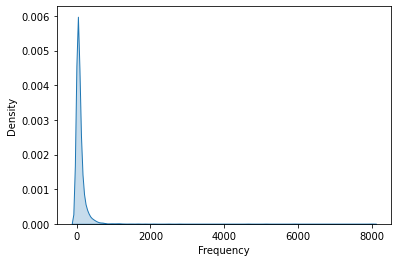

In [17]:
sns.kdeplot(customers['Frequency'], shade=True)

<AxesSubplot:xlabel='MonetaryValue', ylabel='Density'>

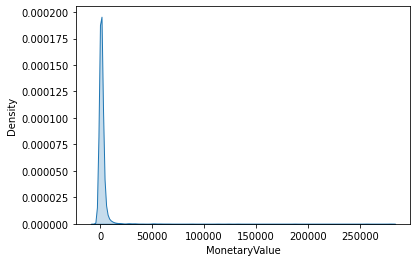

In [18]:
sns.kdeplot(customers['MonetaryValue'], shade=True)

In [19]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(6,6))
    sns.histplot(customers[x], ax=ax[0,0], kde=True)
    sns.histplot(np.log(customers[x]), ax=ax[0,1], kde=True)
    sns.histplot(np.sqrt(customers[x]), ax=ax[1,0], kde=True)
    sns.histplot(stats.boxcox(customers[x])[0], ax=ax[1,1], kde=True)
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

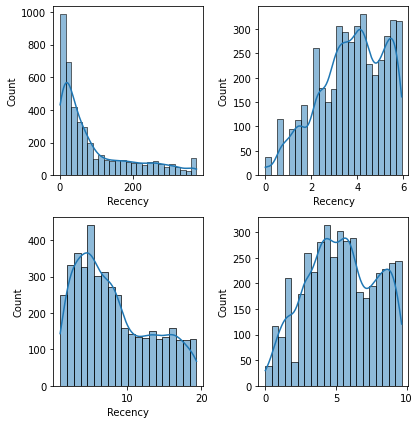

1.25
-0.45
0.6
-0.07


In [20]:
analyze_skewness('Recency')

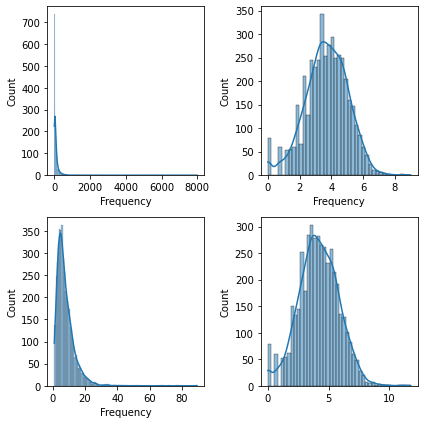

18.15
-0.24
3.2
0.0


In [21]:
analyze_skewness('Frequency')

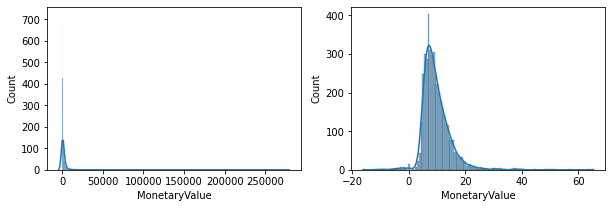

21.71
2.29


In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.histplot(customers['MonetaryValue'], ax=ax[0] , kde=True)
sns.histplot(np.cbrt(customers['MonetaryValue']), ax=ax[1], kde=True)
plt.show()
print(customers['MonetaryValue'].skew().round(2))
print(np.cbrt(customers['MonetaryValue']).skew().round(2))

In [23]:
pd.Series(np.cbrt(customers['MonetaryValue'])).values

array([ 0.        , 16.27392924, 12.15818345, ...,  5.61043971,
       12.79537593, 12.24781024])

In [24]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
4367,8.932980,2.460908,5.652483
4368,7.949051,2.058202,4.323541
4369,2.449000,2.762414,5.610440
4370,1.544575,8.057611,12.795376
4371,5.087438,4.808490,12.247810


In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[-0.  0. -0.]
[1. 1. 1.]


In [26]:
customers_normalized

array([[ 1.60660756, -2.09807168, -1.92564704],
       [-1.69623952,  1.15134635,  1.33054192],
       [ 0.31761476, -0.22431569,  0.50703791],
       ...,
       [-1.18669014, -0.85048403, -0.80307538],
       [-1.55463945,  2.36366091,  0.63453134],
       [-0.11328792,  0.391469  ,  0.52497099]])

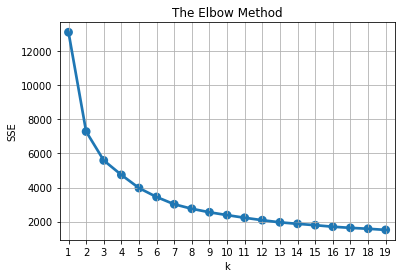

In [27]:
from sklearn.cluster import KMeans
import seaborn as sns
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.grid()
plt.show()

In [28]:
sse

{1: 13115.999999999969,
 2: 7285.776650964659,
 3: 5590.071216742385,
 4: 4740.977059176007,
 5: 3968.6720950905906,
 6: 3443.036052393825,
 7: 3016.704304392221,
 8: 2751.125716324566,
 9: 2546.6352733219783,
 10: 2379.218343773648,
 11: 2223.218169811139,
 12: 2081.0617014355894,
 13: 1955.4048852598535,
 14: 1866.965113526246,
 15: 1788.0428494472696,
 16: 1697.7859540243142,
 17: 1631.3742433592147,
 18: 1578.128385263478,
 19: 1510.2940148875712}

In [29]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(4372,)

In [30]:
model.labels_

array([0, 2, 1, ..., 1, 2, 1], dtype=int32)

In [31]:
customers["Cluster"] = model.labels_
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346.0,326,2,0.00,0
12347.0,3,182,4310.00,2
12348.0,76,31,1797.24,1
12349.0,19,73,1757.55,1
12350.0,311,17,334.40,0


In [32]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0        185.28     19.22        352.11  1659
1         42.91     67.52       1008.26  1934
2         18.48    313.69       7401.71   779

In [33]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,1.606608,-2.098072,-1.925647,12346.0,0
1,-1.696240,1.151346,1.330542,12347.0,2
2,0.317615,-0.224316,0.507038,12348.0,1
3,-0.669146,0.423978,0.488997,12349.0,1
4,1.560253,-0.660498,-0.536848,12350.0,0


In [34]:


# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12346.0,0,Recency,1.606608
1,12347.0,2,Recency,-1.696240
2,12348.0,1,Recency,0.317615
3,12349.0,1,Recency,-0.669146
4,12350.0,0,Recency,1.560253


/Users/koushik.saha/Repos/Segmentation/T1/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

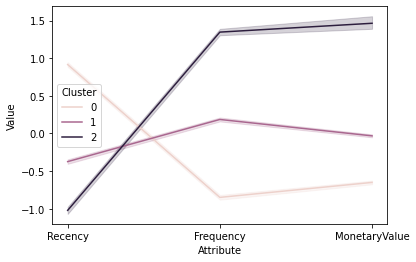

In [35]:
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

In [36]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         185.3      19.2         352.1  1659
1          42.9      67.5        1008.3  1934
2          18.5     313.7        7401.7   779

In [37]:
cluster_avg = customers.groupby('Cluster').mean()
population_avg = customers.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp

,Cluster,Frequency,MonetaryValue,Recency
Cluster,,,,
0,NaN,-0.793471,-0.814528,1.001280
1,NaN,-0.274415,-0.468905,-0.536503
2,NaN,2.371100,2.898799,-0.800418
